# Choose Your Own Adventure Story

- You are about to embark on a choose your own adventure story with none other than Donald Trump! You have the option to inhabit the world of Alice in Wonderland, The Grimms Fairy Tales, or Ulysses. As you move throughout the story, think about your next decision carefully...danger awaits around every turn!

![alt text](choose_your_own_adventure.png "Title")

> Stories to choose from
- Grimms Fairy Tales
- Alice in Wonderland
- Ulysses

#### Resources
> Trump speeches https://github.com/ryanmcdermott/trump-speeches

> TFIDF http://stackoverflow.com/questions/12118720/python-tf-idf-cosine-to-find-document-similarity

> Mad Libs inspiration: https://www.pinterest.com/explore/mad-libs/

> word2vec https://rare-technologies.com/word2vec-tutorial/


#### How to play this game

- This choose your own adventure story works as follows. I have defined four sets of 'story chunks'. You can think of these story chunks as scaffolding for a mad libs style game (i.e. there are variables to plug in nouns, verbs, proper nouns, named entities ...etc). First, before the user starts the game, I generated unigram, bigram, and trigram word probabilities off of a Donald Trump speech corpus. 
- Next, the user picks a story (a world to inhabit). After this, I perform Part Of Speech (POS) and Named Entity Recognition (NER) to extract the relevant nouns, verbs, proper nouns, people ..etc from the story. 
- After this, the user selects three items to bring with them through out story.
- As the user proceeds, he/she will have to enter a sentence incorporating one of the items brought with them in order to decide what part of the story to visit next.
- This user sentence is used as a query for a TF-IDF information retriaval task (This was also tested with Jaccard Similarity). In addition, word2vec is performed on the query and story chunks to determine the most similar word to the ones entered by the user.
- Finally, the user continues to proceed until they reach the end or die.

#### Architecture of system
![alt text](architecture.png "Title")

#### Notes
- The word2vec model is not very stable due to the small size of the training corpus (the various story chunks). We could train on a larger corpora, but I am more interested in the similarity between the user query and current words in the story chunk.
- There are four sections to the game. Everyone will reach the third section, and then it depends on your choice of what to do next if you make it to the fourth section.


In [374]:
from textblob import TextBlob
from collections import Counter
from collections import defaultdict
import nltk
from functools import reduce
import operator
import numpy as np
import re
from spacy.en import English
## The sentence generator module contains a trigram model for sentence generation
from sentence_generator import SentenceGenerator
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
from story_chunks import place_of_story
from sklearn.metrics import accuracy_score
from Evaluation_Metrics_word2vec import accuracy_score_test,word2vec
import seaborn as sns
import gensim
from nltk.stem.wordnet import WordNetLemmatizer
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/jonathanhilgart/anaconda/envs/nlp/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f', 'text', 'choice']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [45]:
# First, we need to decide which world the user would like to inhabit
story_names = ['Grimms fairy tales','Alice in Wonderland','Ulysses']
while True:
    story = input("Which story would you like to read? You can choose Grimms fairy tales, Alice in Wonderland, or Ulysses.")
    if story not in story_names:
        print('Please spell the name correctly.')
    if story in story_names:
        break

Which story would you like to read? You can choose Grimms fairy tales, Alice in Wonderland, or Ulysses.Alice in Wonderland


In [403]:
## Open Trump speeches to create probabilistic sentence generation
with open("speeches.txt") as f:
        text_trump = f.read()
#Clean trump text
text= re.sub(r'[-!@#$%^&*()\n_]+',' ',text_trump)
text = text.lower() ## lower the letters to increase the number of matches
#Token the Trump words, count the frequency of each token, and create a unigram, bigram, and trigram dictionary
## Inside SentenceGenerator we are tokenizing the text, creating counters of the token,
#and then craeting unigram, bigram, and trigram probability distribution over the corpus
trump_story = SentenceGenerator(text)

- Evaluate what lemmatizing would do to the Trump text

In [388]:
nltk.tokenize.word_tokenize(text[:200])

['\ufeffspeech',
 '1',
 '...',
 'thank',
 'you',
 'so',
 'much',
 '.',
 'that',
 "'s",
 'so',
 'nice',
 '.',
 'is',
 "n't",
 'he',
 'a',
 'great',
 'guy',
 '.',
 'he',
 'does',
 "n't",
 'get',
 'a',
 'fair',
 'press',
 ';',
 'he',
 'does',
 "n't",
 'get',
 'it',
 '.',
 'it',
 "'s",
 'just',
 'not',
 'fair',
 '.',
 'and',
 'i',
 'have',
 'to',
 'tell',
 'you',
 'i',
 "'m",
 'here',
 ',',
 'and',
 'very',
 'strongly',
 'here',
 ',']

In [402]:
lmtzr = WordNetLemmatizer()
[lmtzr.lemmatize(i) for i in nltk.tokenize.word_tokenize(text[:200])]

['\ufeffspeech',
 '1',
 '...',
 'thank',
 'you',
 'so',
 'much',
 '.',
 'that',
 "'s",
 'so',
 'nice',
 '.',
 'is',
 "n't",
 'he',
 'a',
 'great',
 'guy',
 '.',
 'he',
 'doe',
 "n't",
 'get',
 'a',
 'fair',
 'press',
 ';',
 'he',
 'doe',
 "n't",
 'get',
 'it',
 '.',
 'it',
 "'s",
 'just',
 'not',
 'fair',
 '.',
 'and',
 'i',
 'have',
 'to',
 'tell',
 'you',
 'i',
 "'m",
 'here',
 ',',
 'and',
 'very',
 'strongly',
 'here',
 ',']

- Lemmatizing appears to make the Trump text more un-readable (does is transformed to doe). Also stemming is not appropriate here  since the goal is to generate natural language; it is best to keep the words as unadultered as possible. The only exception is making everything lowercase. This helps improve the match rate for the unigram/bigram/ and trigram models.
- In addition, I used a simple backoff model for trigram/bigrams where if the word was not present (for a given input), then backoff one level (i.e. if at Trigram look at Bigram, Bigram look at unigram);then, average the probabiliy of the word combination one level down over the number of words.
    - For example, if I have the trigram 'this is great', but I do not have 'this is great' in my corpus. Then, I would look at the bigram of 'this is'; if that was in my corpus, I would divide the probability here by two and use that as the backoff probability for 'this is great'.

In [449]:
## Open Alice in Wonderland for NER evaluation
with open("alice_in_wonderland_copy.txt") as f:
        text_alice = f.read()
## Open the appropriate story based upon the user input

if story =='Alice in Wonderland':
    with open("alice_in_wonderland_copy.txt") as f:
        text_s = f.read()
elif story =='Grimms fairy tales':
    with open("grimms_fairy_tales.txt") as f:
        text_s = f.read()
elif story =='Ulysses':
    with open("ulysses_copy.txt") as f:
        text_s = f.read()
#Clean the text. Remove all punctuation except for periods, question marks, and exclamation points.

text_t = re.sub(r'[-!@#$%^&*()\n_]+',' ',text_s)
text_a = re.sub(r'[-!@#$%^&*()\n_]+',' ',text_alice)
text_a_notprocessed = text_alice

lmtzr = WordNetLemmatizer()
text_t_lemmatized =''
### lemmatize the text. Below, this worked well for Alice in Wonderland.
for i in nltk.tokenize.word_tokenize(text_t):
    text_t_lemmatized+=lmtzr.lemmatize(i)+' '

blob_text_story = TextBlob(text_t_lemmatized)
blob_text_alice = TextBlob(text_a)
blob_text_alice_unprocessed = TextBlob(text_a_notprocessed)

- Lemmatization works better for NER. Look at the differences for Alice in Wonderland below.

In [442]:
text_a[:200]

"ALICE'S ADVENTURES IN WONDERLAND Lewis Carroll THE MILLENNIUM FULCRUM EDITION 3.0 CHAPTER I. Down the Rabbit Hole Alice was beginning to get very tired of sitting by her sister on the bank, and of hav"

In [444]:
# This will change is another story besides Alice in Wonderland is choosen.
text_t_lemmatized[:200]

"ALICE 'S ADVENTURES IN WONDERLAND Lewis Carroll THE MILLENNIUM FULCRUM EDITION 3.0 CHAPTER I . Down the Rabbit Hole Alice wa beginning to get very tired of sitting by her sister on the bank , and of h"

In [445]:
blob_text_story[:200]

TextBlob("ALICE 'S ADVENTURES IN WONDERLAND Lewis Carroll THE MILLENNIUM FULCRUM EDITION 3.0 CHAPTER I . Down the Rabbit Hole Alice wa beginning to get very tired of sitting by her sister on the bank , and of h")

In [440]:
## This in the final POS used
#POS for the story ## JJ - adjective ##NN - noun ##NNS - common noun plural ## NNP - proper noun plural #VB - verb
pos_entities = defaultdict(list)
for word,pos in blob_text_story.tags:
    if pos != "":
        pos_entities[pos].append(str(word).lower())

In [448]:
## THis is the final NER used. Other evaluations below.
#NER for the story characters and places - Entites {'GPE', 'CARDINAL', 'PRODUCT',
#'DATE', 'ORG', 'WORK_OF_ART', 'NORP', 'QUANTITY', 'TIME', 'PERSON', 'ORDINAL', 'MONEY', 'LOC', 'LANGUAGE', 'FAC'}
# takes ~ 2 minutes
nlp = English()
ner_story_tokens = nlp(text_t_lemmatized)
possible_entities = defaultdict(list)
for token in ner_story_tokens:
    if token.ent_type_ != "":
        if str(token) in possible_entities.values():
            pass
        else:
            if len(token)<3: ## check that it is an actual entity 
                pass
            else:
                possible_entities[token.ent_type_].append(str(token).lower())

## Named Entity Evaluation and Part of Speech Evaluation using Alice in Wonderland text
- We will evaluate both processed text and raw text. Precessed is the removal of special characters and some punctuation marks.
- Data for this section at the end of this notebook


#### Processed text first

In [56]:
## duplicate the loop above for Alice in Wonderland

nlp = English()
ner_story_tokens_alice = nlp(text_a)
possible_entities_alice = defaultdict(list)
for token in ner_story_tokens_alice:
    if token.ent_type_ != "":
        if str(token) in possible_entities_alice.values():
            pass
        else:
            if len(token)<3: ## check that it is an actual entity 
                pass
            else:
                possible_entities_alice[token.ent_type_].append(str(token).lower())
## turn the list into a set  
possible_entities_set ={}
for k in possible_entities_alice.keys():
    possible_entities_set[k]= set(possible_entities_alice[k])

In [104]:
## duplicate the loop above for Alice in Wonderland

#POS for the story ## JJ - adjective ##NN - noun ##NNS - common noun plural ## NNP - proper noun plural #VB - verb
pos_entities_alice = defaultdict(list)
for word,pos in blob_text_alice.tags:
    if pos != "":
        pos_entities_alice[pos].append(str(word).lower())

#### Not processed text second

In [275]:
## duplicate the loop above for Alice in Wonderland with unprocessed text

nlp = English()
ner_story_tokens_alice_notprocessed = nlp(text_a_notprocessed)
possible_entities_alice_notprocessed = defaultdict(list)
for token in ner_story_tokens_alice_notprocessed:
    if token.ent_type_ != "":
        if str(token) in possible_entities_alice_notprocessed.values():
            pass
        else:
            if len(token)<3: ## check that it is an actual entity 
                pass
            else:
                possible_entities_alice_notprocessed[token.ent_type_].append(str(token).lower())


In [277]:
## duplicate the loop above for Alice in Wonderland - with unprocessed text

#POS for the story ## JJ - adjective ##NN - noun ##NNS - common noun plural ## NNP - proper noun plural #VB - verb
pos_entities_alice_unprocessed = defaultdict(list)
for word,pos in blob_text_alice_unprocessed.tags:
    if pos != "":
        pos_entities_alice_unprocessed[pos].append(str(word).lower())

In [311]:
### USE NLTK to compare POS to
pos_entities_alice_nltk_unprocessed = defaultdict(list)
for w,tag in nltk.pos_tag(nltk.tokenize.word_tokenize(text_a_notprocessed)):
    if tag !='':
        pos_entities_alice_nltk_unprocessed[tag].append(str(w).lower())
        


#### Lemmatized Alice in Wonderland text
- Used on text that had punctuation removed

In [419]:
## duplicate the loop above for Alice in Wonderland - lemmatized on processed text

nlp = English()
ner_story_tokens_alice_lemm = nlp(text_a_lemmatized)
possible_entities_alice_lemm = defaultdict(list)
for token in ner_story_tokens_alice_lemm:
    if token.ent_type_ != "":
        if str(token) in possible_entities_alice_lemm.values():
            pass
        else:
            if len(token)<3: ## check that it is an actual entity 
                pass
            else:
                possible_entities_alice_lemm[token.ent_type_].append(str(token).lower())


In [433]:
set(possible_entities_alice_lemm['LANGUAGE'])

{'english', 'french'}

## Below, are the 'correct' items from each  NER section.  I also looked at TextBlob POS accuracy.
- Note, I definitely missed some items here. However, this should give a rough indication of performance.
- Feel free to skip the the actual story section.


#### NER Evaluation - Text Processing


In [325]:
num_correct_person = 0 
num_incorrect_person = 0
for person in possible_entities_set['PERSON']:
    if person in correct_person_entities:
        num_correct_person+=1
    else:
        num_incorrect_person+=1
alice_person_accuracy = num_correct_person/(num_correct_person+num_incorrect_person)
print('Accuracy for the person NER task for Alice in Wonderland is {:.2%}'.format(num_correct_person/(num_correct_person+num_incorrect_person)))

Accuracy for the person NER task for Alice in Wonderland is 63.38%


In [326]:
num_correct_org = 0 
num_incorrect_org = 0
for p in possible_entities_set['ORG']:
    if p in correct_org_entities:
        num_correct_org+=1
    else:
        num_incorrect_org+=1
alice_org_accuracy = num_correct_org/(num_correct_org+num_incorrect_org)
print('Accuracy for the org NER task for Alice in Wonderland is {:.2%}'.format(num_correct_org/(num_correct_org+num_incorrect_org)))

Accuracy for the org NER task for Alice in Wonderland is 38.18%


In [327]:
num_correct_date = 0 
num_incorrect_date = 0
for p in possible_entities_set['DATE']:
    if p in correct_date_entities:
        num_correct_date+=1
    else:
        num_incorrect_date+=1
alice_date_accuracy = num_correct_date/(num_correct_date+num_incorrect_date)
print('Accuracy for the date NER task for Alice in Wonderland is {:.2%}'.format(alice_date_accuracy))

Accuracy for the date NER task for Alice in Wonderland is 56.25%


In [328]:
num_correct_lang = 0 
num_incorrect_lang = 0
for p in possible_entities_set['LANGUAGE']:
    if p in correct_lang_entities:
        num_correct_lang+=1
    else:
        num_incorrect_lang+=1
alice_lang_accuracy = num_correct_lang/(num_correct_lang+num_incorrect_lang)
print('Accuracy for the language NER task for Alice in Wonderland is {:.2%}'.format(alice_lang_accuracy))

Accuracy for the language NER task for Alice in Wonderland is 100.00%


#### NER on unprocessed text

In [329]:
num_correct_person_notprocessed = 0 
num_incorrect_person_notprocessed = 0
for person in possible_entities_alice_notprocessed['PERSON']:
    if person in correct_person_entities_notprocessed:
        num_correct_person_notprocessed+=1
    else:
        num_incorrect_person_notprocessed+=1
alice_person_notprocessed_accuracy = num_correct_person_notprocessed/(num_correct_person_notprocessed+num_incorrect_person_notprocessed)
print('Accuracy for the person NER task with unprocessed text for Alice in Wonderland is {:.2%}'.format(alice_person_notprocessed_accuracy))

Accuracy for the person NER task with unprocessed text for Alice in Wonderland is 86.16%


In [330]:
num_correct_org_notprocessed = 0 
num_incorrect_org_notprocessed = 0
for p in possible_entities_alice_notprocessed['ORG']:
    if p in correct_org_entities_notprocessed:
        num_correct_org_notprocessed+=1
    else:
        num_incorrect_org_notprocessed+=1
alice_org_accuracy_notprocessed = num_correct_org_notprocessed/(num_correct_org_notprocessed+num_incorrect_org_notprocessed)
print('Accuracy for the org NER task with unprocessed text for Alice in Wonderland is {:.2%}'.format(alice_org_accuracy_notprocessed))

Accuracy for the org NER task with unprocessed text for Alice in Wonderland is 51.01%


In [331]:
num_correct_date_notprocessed = 0 
num_incorrect_date_notprocessed = 0
for p in possible_entities_set['DATE']:
    if p in correct_date_entities:
        num_correct_date_notprocessed+=1
    else:
        num_incorrect_date_notprocessed+=1
alice_date_accuracy_notprocessed = num_correct_date_notprocessed/(num_correct_date_notprocessed+num_incorrect_date_notprocessed)
print('Accuracy for the date NER task with unprocessed text for Alice in Wonderland is {:.2%}'.format(alice_date_accuracy_notprocessed))

Accuracy for the date NER task with unprocessed text for Alice in Wonderland is 56.25%


In [332]:
###languages are the same for processed and unprocessed text

alice_lang_accuracy_notprocesed = alice_lang_accuracy
print('Accuracy for the language NER task with unprocessed data for Alice in Wonderland is {:.2%}'.format(alice_lang_accuracy_notprocesed))

Accuracy for the language NER task with unprocessed data for Alice in Wonderland is 100.00%


#### NER on lemmatized and pre-processed text

In [424]:
num_correct_person_lemm = 0 
num_incorrect_person_lemm = 0
for person in possible_entities_alice_lemm['PERSON']:
    if person in correct_person_lemm:
        num_correct_person_lemm+=1
    else:
        num_incorrect_person_lemm+=1
alice_person_accuracy_lemm = num_correct_person_lemm/(num_correct_person_lemm+num_incorrect_person_lemm)
print('Accuracy for the person NER task with lemmatization  and processed textfor Alice in Wonderland is {:.2%}'.format(alice_person_accuracy_lemm))

Accuracy for the person NER task with lemmatization for Alice in Wonderland is 91.96%


In [428]:
num_correct_org_lemm = 0 
num_incorrect_org_lemm= 0
for p in possible_entities_alice_lemm['ORG']:
    if p in correct_org_lemm:
        num_correct_org_lemm+=1
    else:
        num_incorrect_org_lemm+=1
alice_org_accuracy_lemm = num_correct_org_lemm/(num_correct_org_lemm+num_incorrect_org_lemm)
print('Accuracy for the org NER task with processed text and lemmatization for Alice in Wonderland is {:.2%}'.format(alice_org_accuracy_lemm))

Accuracy for the org NER task with processed text and lemmatization for Alice in Wonderland is 38.46%


In [432]:
num_correct_date_lemm = 0 
num_incorrect_date_lemm = 0
for p in possible_entities_alice_lemm['DATE']:
    if p in correct_date_lemm:
        num_correct_date_lemm+=1
    else:
        num_incorrect_date_lemm+=1
alice_date_accuracy_lemm = num_correct_date_lemm/(num_correct_date_lemm+num_incorrect_date_lemm)
print('Accuracy for the date NER task with lemmatization and processed text for Alice in Wonderland is {:.2%}'.format(alice_date_accuracy_lemm))

Accuracy for the date NER task with lemmatization and processed text for Alice in Wonderland is 50.00%


In [434]:
###languages are the same for processed and unprocessed text and lemmatized

alice_lang_accuracy_lemm = alice_lang_accuracy
print('Accuracy for the language NER task with processed data and lemmatization for Alice in Wonderland is {:.2%}'.format(alice_lang_accuracy_lemm))

Accuracy for the language NER task with processed data and lemmatization for Alice in Wonderland is 100.00%


#### POS evaluation - Text processing
- Only looked at TextBlob here

In [333]:
num_correct_nn = 0 
num_incorrect_nn = 0
for p in pos_entities_alice['NN']:
    if p in correct_noun_pos:
        num_correct_nn+=1
    else:
        num_incorrect_nn+=1
alice_nn_accuracy = num_correct_nn/(num_correct_nn+num_incorrect_nn)
print('Accuracy for the NN POS task for Alice in Wonderland is {:.2%}'.format(alice_nn_accuracy))

Accuracy for the NN POS task for Alice in Wonderland is 98.12%


In [334]:
num_correct_nnp = 0 
num_incorrect_nnp = 0
for p in pos_entities_alice['NNP']:
    if p in correct_propernoun_pos:
        num_correct_nnp+=1
    else:
        num_incorrect_nnp+=1
alice_nnp_accuracy = num_correct_nnp/(num_correct_nnp+num_incorrect_nnp)
print('Accuracy for the NNP POS task for Alice in Wonderland is {:.2%}'.format(alice_nnp_accuracy))

Accuracy for the NNP POS task for Alice in Wonderland is 82.26%


In [335]:
num_correct_vb = 0 
num_incorrect_vb = 0
for p in pos_entities_alice['VB']:
    if p in correct_vb_pos:
        num_correct_vb+=1
    else:
        num_incorrect_vb+=1
alice_vb_accuracy = num_correct_vb/(num_correct_vb+num_incorrect_vb)
print('Accuracy for the VB POS task for Alice in Wonderland is {:.2%}'.format(alice_vb_accuracy))

Accuracy for the VB POS task for Alice in Wonderland is 87.78%


In [336]:
num_correct_nns = 0 
num_incorrect_nns = 0
for p in pos_entities_alice['NNS']:
    if p in correct_nns_pos:
        num_correct_nns+=1
    else:
        num_incorrect_nns+=1
alice_nns_accuracy = num_correct_nns/(num_correct_nns+num_incorrect_nns)
print('Accuracy for the NNS POS task for Alice in Wonderland is {:.2%}'.format(alice_nns_accuracy))

Accuracy for the NNS POS task for Alice in Wonderland is 92.46%


#### Results of Accuracy Evaluation - POS / NER
- Evaluate the impact of text processing

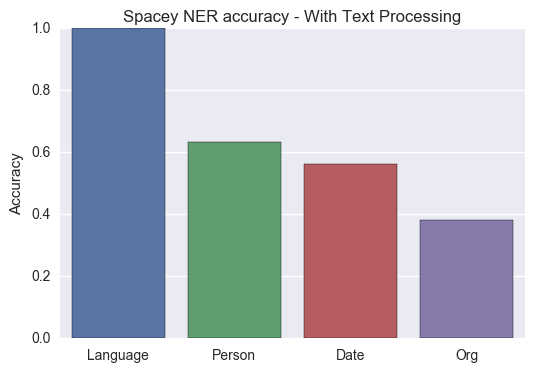

In [337]:
plt.title('Spacey NER accuracy - With Text Processing')
sns.barplot(x=['Language','Person','Date','Org']\
            ,y=[alice_lang_accuracy,alice_person_accuracy,alice_date_accuracy,alice_org_accuracy])

plt.ylabel('Accuracy');

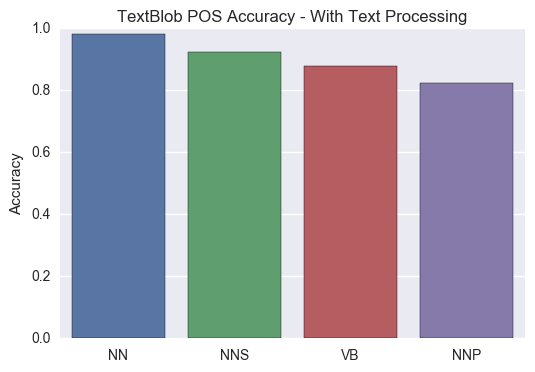

In [338]:
plt.title('TextBlob POS Accuracy - With Text Processing')
sns.barplot(x=['NN','NNS','VB','NNP']\
            ,y=[alice_nn_accuracy,alice_nns_accuracy,alice_vb_accuracy,alice_nnp_accuracy])
plt.ylabel('Accuracy');

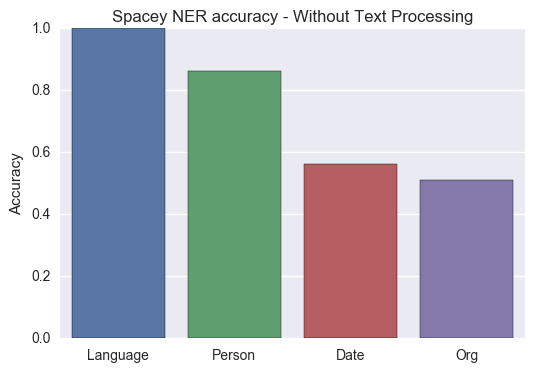

In [341]:
plt.title('Spacey NER accuracy - Without Text Processing')
sns.barplot(x=['Language','Person','Date','Org']\
            ,y=[alice_lang_accuracy_notprocesed,alice_person_notprocessed_accuracy,alice_date_accuracy_notprocessed,\
                alice_org_accuracy_notprocessed])
plt.ylabel('Accuracy');

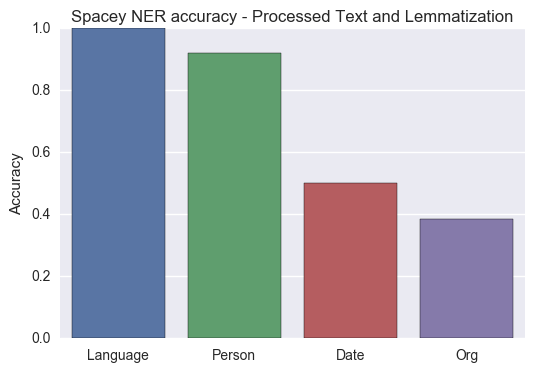

In [436]:
plt.title('Spacey NER accuracy - Processed Text and Lemmatization')
sns.barplot(x=['Language','Person','Date','Org']\
            ,y=[alice_lang_accuracy_lemm,alice_person_accuracy_lemm,alice_date_accuracy_lemm,\
                alice_org_accuracy_lemm])
plt.ylabel('Accuracy');

#### As we can see above, our NER and POS recognition is not perfect. Therefore, some of the entities we plug in may not make sense.

In [450]:
## find the most common entities used in the story
people_counter = Counter(possible_entities['PERSON'])
place_counter = Counter(possible_entities['GPE'])
org_counter = Counter(possible_entities['ORG'])
language_counter = Counter(possible_entities['LANGUAGE'])
product_counter = Counter(possible_entities['PRODUCT'])
### find the most common POS for different words
single_noun_com_counter= Counter(pos_entities['NN'])
plural_noun_com_counter = Counter(pos_entities['NNS'])
verb_counter= Counter(pos_entities['VB'])

## We have a text generator for Trump and named entity recognition / part of speech tagging completed for the story; now, move onto the actual adventure!
- Count the most common occurance of nouns, verbs, named entities to represent the major variables that will be plugged into our mad libs scaffolding.

In [451]:
### need to keep track of the different entities used and in what order
protagonist=people_counter.most_common(1)[0][0].lower()
antagonist = people_counter.most_common(2)[1][0].lower()
place_one= place_counter.most_common(1)[0][0].lower()
place_two = place_counter.most_common(2)[1][0].lower()
language_one = language_counter.most_common(1)[0][0].lower()
single_noun_one =single_noun_com_counter.most_common(1)[0][0].lower()
single_noun_two = single_noun_com_counter.most_common(2)[1][0].lower()
plural_noun_one = plural_noun_com_counter.most_common(1)[0][0].lower()
plural_noun_two = plural_noun_com_counter.most_common(2)[1][0].lower()
verb_one = verb_counter.most_common(1)[0][0].lower()
verb_two = verb_counter.most_common(2)[1][0].lower()
verb_three = verb_counter.most_common(3)[2][0].lower()
#utility_item_chosen, funny_item_chosen, transportation_item_chosen
utility_items='pocketknife flashlight'.split(' ')
funny_items='half-eaten-sandwich broken-lightbulb'.split(' ')
transportation_items = 'skateboard bike'.split(' ')

- Look at the different entities and parts of speech you will be interacting with.

In [452]:
protagonist

'alice'

In [453]:
antagonist

'gryphon'

In [454]:
place_one

'rome'

In [455]:
place_two

'paris'

In [456]:
single_noun_one

'thing'

In [457]:
single_noun_two

'time'

In [458]:
verb_one

'be'

In [459]:
verb_two

'have'

# Start the story
- For the information retrieval section, I used TF-IDF with cosine similarity. In the evaluation section, we can see this worked much better than Jaccard Similarity.

In [357]:
print('Welcome to a choose your own adventure story!\n Below you will pick a story, and you will explore that world with a campanion. \
Throughout the story, you will have different options for next steps to take. \
Your goal is to choose the options that lead you safely on your adventure.  \
However, be careful! Danger awaits around every turn.')

Welcome to a choose your own adventure story!
 Below you will pick a story, and you will explore that world with a campanion. Throughout the story, you will have different options for next steps to take. Your goal is to choose the options that lead you safely on your adventure.  However, be careful! Danger awaits around every turn.


In [358]:
###### The first section of the story   
print('You awake and look around "Hey, I think I recognize this place", you think to yourself. You realize \
that you are sitting down on something, you can not quite tell what, but you feel strangely awake. \
You turn to your right and see {} from {}. On your left, you see \
Donald Trump. You wonder where you are and how this all happened, but before you can think too much \
Trump turns to you and says '.format(protagonist,story),\
      trump_story.sentence_generate(3),\
        'Well that was weird you think to yourself. Shaking it off, you turn to {} who says, \
        "Welcome to {}! We are excited to have you and your friend explore our \
        world. Before we start what do you want to bring with you on your \
        journey?'.format(protagonist,story),\
        "'Please pick one from each category,' instructes {}.".format(protagonist))
print()## keep track of the options chosen
while True:
    print()
    print(utility_items)
    utility_item_chosen = input("Which item would you like?")
    if utility_item_chosen in utility_items:
        break
    else:
        print('Please spell the word correctly without the quotes')
while True:
    print()
    print(funny_items)
    funny_item_chosen = input("Which of these would you like?")
    if funny_item_chosen in funny_items:
        break
    else:
        print('Please spell the word correctly without the quotes')
while True:
    print()
    print(transportation_items)
    trans_item_chosen = input('Which of these would you like?')
    if trans_item_chosen in transportation_items:
        break
    else:
        print('Please spell the word correctly without the quotes')


You awake and look around "Hey, I think I recognize this place", you think to yourself. You realize that you are sitting down on something, you can not quite tell what, but you feel strangely awake. You turn to your right and see alice from Alice in Wonderland. On your left, you see Donald Trump. You wonder where you are and how this all happened, but before you can think too much Trump turns to you and says  Favored for someone else in either party , or john deere , `` make america great again . I have a victory and let them fight each other . It was even made .  Well that was weird you think to yourself. Shaking it off, you turn to alice who says,         "Welcome to Alice in Wonderland! We are excited to have you and your friend explore our         world. Before we start what do you want to bring with you on your         journey? 'Please pick one from each category,' instructes alice.


['pocketknife', 'flashlight']
Which item would you like?pocketknife

['half-eaten-sandwich', 'bro

In [359]:
#First choice by the user
choice1=[]
while True:
    choice = input('Please write a sentence for what you would like to do next\
    incorporating an item you have choosen.If you want to see the items you have, type items.')  
    if choice =='items':
        print(utility_item_chosen,trans_item_chosen,funny_item_chosen)
    else:
        choice1.append(choice)
        break

Please write a sentence for what you would like to do next    incorporating an item you have choosen.If you want to see the items you have, type items.run away with my sando


### After each block of story, the sentence entered by the user will be used by an IR system (tf-idf with cosine similarity) to pick the  next part of the story.
- In addition, word2vec will pull of the more similar words in the current story chunk to the words entered by a user (assuming the words entered by the user are in the story chunk. If not, they are not used for the word2vec model). 

In [360]:
# the first section of possible texts for the story
storychunk_one = place_of_story(1,protagonist,antagonist,place_one,language_one,\
                        trump_story.sentence_generate(2),place_two,\
                          single_noun_one,single_noun_two,plural_noun_one,plural_noun_two,verb_one,verb_two,verb_three) #protagonist

In [361]:
word2vec(storychunk_one,choice1)

The words most similar (in the given story chunk) to the following query words (vectors added together): ['run', 'with']


[('be', 0.35223403573036194),
 ('happily', 0.27199500799179077),
 ('that', 0.2559588849544525),
 ('do', 0.2550390958786011),
 ('who', 0.24346351623535156),
 ('have', 0.24343758821487427),
 ('trump', 0.23861822485923767),
 ('alice', 0.23612971603870392),
 ('time', 0.23193146288394928),
 ('even', 0.21129761636257172)]

# Retrieve the next story chunk

In [362]:
# TFIDF with cosine similarity
tfidf_one = TfidfVectorizer() 
tf_idf_storyone= tfidf_one.fit_transform(storychunk_one) ##tf-idf on the possible story chunks in storychunk_one
choice1_tfidf = tfidf_one.transform(choice1) ## turn the user sentence into a vector
cosine_sim_one = linear_kernel(tf_idf_storyone,choice1_tfidf).flatten() ## cosine similarity between the story chunks and user sentence
re.sub(r'(\t)','',storychunk_one[cosine_sim_one.argsort()[::-1][0]]) ##return the story chunk

'You have the feeling that something bad was going to happen so you pull out your pocketknife. alice looks at you and asks,"So what do youthink you are going to do with that? That is not going to save you. You notice dormouse in the distance and you yell to trump "Run for it!" . Where should you run to?'

In [363]:
choice2=[]
while True:
    choice = input('Please write a sentence for what you would like to do next \
    incorporating an item you have choosen.If you want to see the items you have, type items.')  
    if choice =='items':
        print(utility_item_chosen,trans_item_chosen,funny_item_chosen)
    else:
        choice2.append(choice)
        break
        

Please write a sentence for what you would like to do next     incorporating an item you have choosen.If you want to see the items you have, type items.run away to eat my half-eaten-sandwich


## Second story chunk

In [364]:
# the second section of possible texts for the story
storychunk_two = place_of_story(2,protagonist,antagonist,place_one,language_one,\
                        trump_story.sentence_generate(3),place_two,\
                          single_noun_one,single_noun_two,plural_noun_one,plural_noun_two,verb_one,verb_two,verb_three) 
tfidf_two = TfidfVectorizer()  #create a model
tf_idf_storytwo= tfidf_two.fit_transform(storychunk_two) ##tf-idf on the possible story chunks in storychunk_one
choice2_tfidf = tfidf_two.transform(choice2) ## turn the user sentence into a vector
cosine_sim_two = linear_kernel(tf_idf_storytwo,choice2_tfidf).flatten() ## cosine similarity between the story chunks and user sentence
re.sub(r'(\t)','',storychunk_two[cosine_sim_two.argsort()[::-1][0]]) ##return the story chunk

'Feeling upset, you take out your half-eaten-sandwich from lunch and throw it on the ground. You watch the jelly ooze onto the ground with disappointment.   Trump turns to your with bulging eyes and  a hand over his stomach and says He stopped . And what are we going to do this thing is if you want to fix our rigged system so we have . Record , record , putting the american people can’t do that one ?  . Now what?  '

In [365]:
## Top related words for story chunk two
word2vec(storychunk_two,choice2)

The words most similar (in the given story chunk) to the following query words (vectors added together): ['to', 'my', 'half-eaten-sandwich']


[('the', 0.3080666661262512),
 ('emits', 0.26748454570770264),
 ('with', 0.2587265074253082),
 ('while', 0.2566555142402649),
 ('thinking', 0.2508894205093384),
 ('before', 0.24582356214523315),
 ('end', 0.23640254139900208),
 ('was', 0.22884947061538696),
 ('trump', 0.22222858667373657),
 ('exclaims', 0.22191467881202698)]

In [366]:
choice3=[]
while True:
    choice = input('Please write a sentence for what you would like to do next \
    incorporating an item you have choosen.If you want to see the items you have, type items.')  
    if choice =='items':
        print(utility_item_chosen,trans_item_chosen,funny_item_chosen)
    else:
        choice3.append(choice)
        break
        

Please write a sentence for what you would like to do next     incorporating an item you have choosen.If you want to see the items you have, type items.let's go explore another part with my half-eaten-sandwich


## Third story chunk

In [367]:
# the third section of possible texts for the story
storychunk_three = place_of_story(3,protagonist,antagonist,place_one,language_one,\
                        trump_story.sentence_generate(4),place_two,\
                          single_noun_one,single_noun_two,plural_noun_one,plural_noun_two,verb_one,verb_two,verb_three) 

tfidf_three = TfidfVectorizer()  #create a model
tf_idf_storythree= tfidf_three.fit_transform(storychunk_three) ##tf-idf on the possible story chunks in storychunk_one
choice3_tfidf = tfidf_three.transform(choice3) ## turn the user sentence into a vector
cosine_sim_three = linear_kernel(tf_idf_storythree,choice3_tfidf).flatten() ## cosine similarity between the story chunks and user sentence
third_section = re.sub(r'(\t)','',storychunk_three[cosine_sim_three.argsort()[::-1][0]] )
third_section ##return the story chunk

'You quickly take out what is left of your half-eaten-sandwich and show it to alice.  "Good," sayd alice, "We can use this to pay off gryphon and get you to the way".   You wonder where that is, or who gryphon is, but you follow alice. What should you do now?'

In [368]:
## Top related words for story chunk three
word2vec(storychunk_three,choice3)

The words most similar (in the given story chunk) to the following query words (vectors added together): ['with', 'half-eaten-sandwich']


[('above', 0.3896535634994507),
 ('flashlight', 0.31827521324157715),
 ('the', 0.26740217208862305),
 ('storm', 0.24488885700702667),
 (')', 0.22980721294879913),
 ('trump', 0.22599923610687256),
 ('to', 0.21912923455238342),
 ('before', 0.21571339666843414),
 ('what', 0.21542954444885254),
 ('ash', 0.2089400738477707)]

In [369]:
if 'dead' in third_section:
    print('You died with Trump by your side. Better luck next time!')
elif 'died' in third_section:
    print('You died with Trump by your side. Better luck next time!')
else:
    choice4=[]
    while True:
        choice = input('Please write a sentence for what you would like to do next \
        incorporating an item you have choosen.If you want to see the items you have, type items.')  
        if choice =='items':
            print(utility_item_chosen,trans_item_chosen,funny_item_chosen)
        else:
            choice4.append(choice)
            break


Please write a sentence for what you would like to do next         incorporating an item you have choosen.If you want to see the items you have, type items.let's explore some more with my bike


## Fourth story chunk (if you make it this far)

In [370]:
#The fourth chunck - Only go here if the user made it here
storychunk_four = place_of_story(4,protagonist,antagonist,place_one,language_one,\
                        trump_story.sentence_generate(2),place_two,\
                          single_noun_one,single_noun_two,plural_noun_one,plural_noun_two,verb_one,verb_two,verb_three,story) 

tfidf_four = TfidfVectorizer()  #create a model
tf_idf_storyfour= tfidf_four.fit_transform(storychunk_four) ##tf-idf on the possible story chunks in storychunk_one
choice4_tfidf = tfidf_four.transform(choice4) ## turn the user sentence into a vector
cosine_sim_four = linear_kernel(tf_idf_storyfour,choice4_tfidf).flatten() ## cosine similarity between the story chunks and user sentence
fourth_section = re.sub(r'(\t)','',storychunk_four[cosine_sim_four.argsort()[::-1][0]] )
fourth_section ##return the story chunk

' "Congratulations!" says alice "You defeated gryphon and survived Alice in Wonderland. Best of luck in your future adventures" '

- The secret to surviving is using the half eaten sandwich at the third story section :). Now, test the accuracy of the IR system.

## Evaluation Metrics
> Accuracy

- To evaluate our system, we want to look at the sentence entered by our users that contains an item they choose (i.e. bike) and pick the response that has that item. Since there is only one correct answer for each query, we will look at the average accuracy using each item over a number of queries.
- We will examine both TF-IDF with cosine similarity as well as Jaccard Similarity here.

In [178]:
test_chunk_one = place_of_story(1,protagonist,antagonist,place_one,language_one,\
                        trump_story.sentence_generate(3),place_two,\
                          single_noun_one,single_noun_two,plural_noun_one,plural_noun_two,verb_one,verb_two,verb_three,story)

In [179]:
test_chunk_two = place_of_story(2,protagonist,antagonist,place_one,language_one,\
                        trump_story.sentence_generate(3),place_two,\
                          single_noun_one,single_noun_two,plural_noun_one,plural_noun_two,verb_one,verb_two,verb_three,story)

In [180]:
test_chunk_three = place_of_story(3,protagonist,antagonist,place_one,language_one,\
                        trump_story.sentence_generate(3),place_two,\
                          single_noun_one,single_noun_two,plural_noun_one,plural_noun_two,verb_one,verb_two,verb_three,story)

In [349]:
list_of_test_one_queries = [['pocketknife'],\
                            ['I like to run with my pocketknife'],\
                            ['This is a flashy fun way to show how cool you are with friends pocketknife'],\
                           ['Do you know who I am that I love to watch Trump with my pocketknife?'],\
                           ['This is incredible!\
                           I love to carve wood and eat food with my own pocketknife even though you know Trump\
                           has a way with words!']]

list_of_test_two_queries =[['half-eaten-sandwich'],
                          ['I like to run around the town with my half-eaten-sandwich'],
                          ["Wow, he really has a way with words with your half-eaten-sandwich"],
                          ['asdf asdf sandwich asdfa'],
                          ['This is lightsaber battle run fight half-eaten-sandwich']]

list_of_test_three_queries = [['bike'],
                             ['i like to ride my bicycle i like to ribe my bike'],
                             ['run away to the furtherst point that you can with your bike'],
                             ['looing at the moon and the stars and trump overhead you jump on the bike'],
                             ['You look around and decide to run and jump on your bike. Good this is good says Trump . I like the way you think.']]

#### Evaluate TF-IDF IR

In [566]:
#First chuck - pocketknife
print(accuracy_score_test(list_of_test_one_queries,test_chunk_one,'pocketknife','tfidf'))
txt,acc_one_pocket,quertxt,query_one = accuracy_score_test(list_of_test_one_queries,test_chunk_one,'pocketknife','tfidf')
q_one = [TextBlob(query_two[i][0]) for i in range(len(query_one))]
avg_len_query_one_pocket = \
int(np.mean(([sum(list(Counter(q_one[i]).values())) for i in range(len(q_one))] )))

## Second Chunk - pocketknife
print(accuracy_score_test(list_of_test_one_queries,test_chunk_two,'pocketknife','tfidf'))
txt,acc_two_pocket,quertxt,query_two = accuracy_score_test(list_of_test_one_queries,test_chunk_two,'pocketknife','tfidf')
q_two = [TextBlob(query_two[i][0]) for i in range(len(query_two))]
avg_len_query_two_pocket= int(np.mean(([sum(list(Counter(q_two[i]).values())) for i in range(len(q_two))] )))

## Third chunk - pocketknife
print(accuracy_score_test(list_of_test_one_queries,test_chunk_three,'pocketknife','tfidf'))
txt,acc_three_pocket,quertxt,query_three = accuracy_score_test(list_of_test_one_queries,test_chunk_three,'pocketknife','tfidf')
q_three = [TextBlob(query_three[0][i]) for i in range(len(query_three))]
avg_len_query_three_pocket= int(np.mean(([sum(list(Counter(q_three[i]).values())) for i in range(len(q_three))] )))


('The accuracy is', 0.8, 'The query that failed was :', [['This is incredible!                           I love to carve wood and eat food with my own pocketknife even though you know Trump                           has a way with words!']])
('The accuracy is', 1.0, 'The correct queries are', [['pocketknife'], ['I like to run with my pocketknife'], ['This is a flashy fun way to show how cool you are with friends pocketknife'], ['Do you know who I am that I love to watch Trump with my pocketknife?'], ['This is incredible!                           I love to carve wood and eat food with my own pocketknife even though you know Trump                           has a way with words!']])
('The accuracy is', 0.8, 'The query that failed was :', [['This is a flashy fun way to show how cool you are with friends pocketknife']])


In [527]:
#First chuck - bicycle
print(accuracy_score_test(list_of_test_three_queries,test_chunk_one,'bike','tfidf'))
txt,acc_one_bike,quertxt,query_one_bike = accuracy_score_test(list_of_test_three_queries,test_chunk_one,'bike','tfidf')
q_one_bike = [TextBlob(query_one_bike[i][0]) for i in range(len(query_one_bike))]
avg_len_query_one_bike= int(np.mean(([sum(list(Counter(q_one_bike[i]).values())) for i in range(len(q_one_bike))] )))
    
#Second Chunk - bicycle
print(accuracy_score_test(list_of_test_three_queries,test_chunk_two,'bike','tfidf'))
txt,acc_two_bike,quertxt,query_two_bike = accuracy_score_test(list_of_test_three_queries,test_chunk_two,'bike','tfidf')
q_two_bike = [TextBlob(query_two_bike[i][0]) for i in range(len(query_two_bike))]
avg_len_query_two_bike= int(np.mean(([sum(list(Counter(q_two_bike[i]).values())) for i in range(len(q_two_bike))] )))
    
#Third chunk
print(accuracy_score_test(list_of_test_three_queries,test_chunk_three,'bike','tfidf'))
txt,acc_three_bike,quertxt,query_three_bike = accuracy_score_test(list_of_test_three_queries,test_chunk_three,'bike','tfidf')
q_three_bike = [TextBlob(query_three_bike[i][0]) for i in range(len(query_three_bike))]
avg_len_query_three_bike= int(np.mean(([sum(list(Counter(q_three_bike[i]).values())) for i in range(len(q_three_bike))] )))

('The accuracy is', 0.8, 'The query that failed was :', [['run away to the furtherst point that you can with your bike']])
('The accuracy is', 0.2, 'The query that failed was :', [['i like to ride my bicycle i like to ribe my bike'], ['run away to the furtherst point that you can with your bike'], ['looing at the moon and the stars and trump overhead you jump on the bike'], ['You look around and decide to run and jump on your bike. Good this is good says Trump . I like the way you think.']])
('The accuracy is', 1.0, 'The correct queries are', [['bike'], ['i like to ride my bicycle i like to ribe my bike'], ['run away to the furtherst point that you can with your bike'], ['looing at the moon and the stars and trump overhead you jump on the bike'], ['You look around and decide to run and jump on your bike. Good this is good says Trump . I like the way you think.']])


### Next - test Jaccard Similarity for the IR task

In [557]:
#First chuck - pocketknife - jaccard
print(accuracy_score_test(list_of_test_one_queries,test_chunk_one,'pocketknife','jaccard'))
txt,acc_one_pocket_jacc,quertxt,query_one_pocket_jacc = accuracy_score_test(list_of_test_one_queries,test_chunk_one,'pocketknife','jaccard')
q_one_pocket_jacc = [TextBlob(query_one_pocket_jacc[i][0]) for i in range(len(query_one_pocket_jacc))]
avg_query_one_pocket_jacc = \
int(np.mean(([sum(list(Counter(q_one_pocket_jacc[i]).values())) for i in range(len(q_one_pocket_jacc))] )))

#Second Chunk - pocketknife - jaccard
print(accuracy_score_test(list_of_test_one_queries,test_chunk_two,'pocketknife','jaccard'))
txt,acc_two_pocket_jacc,quertxt,query_two_pocket_jacc = accuracy_score_test(list_of_test_one_queries,test_chunk_two,'pocketknife','jaccard')
q_two_pocket_jacc = [TextBlob(query_two_pocket_jacc[i][0]) for i in range(len(query_two_pocket_jacc))]
avg_len_query_two_pocket_jacc= \
int(np.mean(([sum(list(Counter(q_two_pocket_jacc[i]).values())) for i in range(len(q_two_pocket_jacc))] )))
    
#Third chunk - pocketknife - jaccard
print(accuracy_score_test(list_of_test_one_queries,test_chunk_three,'pocketknife','jaccard'))
txt,acc_three_pocket_jacc,quertxt,query_three_pocket_jacc = accuracy_score_test(list_of_test_one_queries,test_chunk_three,'pocketknife','jaccard')
q_three_pocket_jacc = [TextBlob(query_three_pocket_jacc[i][0]) for i in range(len(query_three_pocket_jacc))]
avg_len_query_three_pocket_jacc=\
int(np.mean(([sum(list(Counter(q_three_pocket_jacc[i]).values())) for i in range(len(q_three_pocket_jacc))] )))

('The accuracy is', 0.6, 'The query that failed was :', [['Do you know who I am that I love to watch Trump with my pocketknife?'], ['This is incredible!                           I love to carve wood and eat food with my own pocketknife even though you know Trump                           has a way with words!']])
('The accuracy is', 0.4, 'The query that failed was :', [['I like to run with my pocketknife'], ['Do you know who I am that I love to watch Trump with my pocketknife?'], ['This is incredible!                           I love to carve wood and eat food with my own pocketknife even though you know Trump                           has a way with words!']])
('The accuracy is', 0.6, 'The query that failed was :', [['This is a flashy fun way to show how cool you are with friends pocketknife'], ['Do you know who I am that I love to watch Trump with my pocketknife?']])


In [574]:
#First chuck - bike - jaccard
print(accuracy_score_test(list_of_test_three_queries,test_chunk_one,'bike','jaccard'))
txt,acc_one_bike_jacc,quertxt,query_one_bike_jacc = accuracy_score_test(list_of_test_three_queries,test_chunk_one,'bike','jaccard')
q_one_bike_jacc = [TextBlob(query_one_bike_jacc[i][0]) for i in range(len(query_one_bike_jacc))]
avg_query_one_bike_jacc = \
int(np.mean(([sum(list(Counter(q_one_bike_jacc[i]).values())) for i in range(len(q_one_bike_jacc))] )))

#Second Chunk -bike - jaccard
print(accuracy_score_test(list_of_test_three_queries,test_chunk_two,'bike','jaccard'))
txt,acc_two_bike_jacc,quertxt,query_two_bike_jacc = accuracy_score_test(list_of_test_three_queries,test_chunk_two,'bike','jaccard')
q_two_bike_jacc = [TextBlob(query_two_bike_jacc[i][0]) for i in range(len(query_two_bike_jacc))]
avg_len_query_two_bike_jacc= \
int(np.mean(([sum(list(Counter(q_two_bike_jacc[i]).values())) for i in range(len(q_two_bike_jacc))] )))
    
#Third chunk - bike- jaccard
print(accuracy_score_test(list_of_test_three_queries,test_chunk_three,'bike','jaccard'))
txt,acc_three_bike_jacc,quertxt,query_three_bike_jacc = accuracy_score_test(list_of_test_three_queries,test_chunk_three,'bike','jaccard')
q_three_bike_jacc = [TextBlob(query_three_bike_jacc[i][0]) for i in range(len(query_three_bike_jacc))]
avg_len_query_three_bike_jacc=\
int(np.mean(([sum(list(Counter(q_three_bike_jacc[i]).values())) for i in range(len(q_three_bike_jacc))] )))

('The accuracy is', 1.0, 'The correct queries are', [['bike'], ['i like to ride my bicycle i like to ribe my bike'], ['run away to the furtherst point that you can with your bike'], ['looing at the moon and the stars and trump overhead you jump on the bike'], ['You look around and decide to run and jump on your bike. Good this is good says Trump . I like the way you think.']])
('The accuracy is', 0.8, 'The query that failed was :', [['looing at the moon and the stars and trump overhead you jump on the bike']])
('The accuracy is', 0.6, 'The query that failed was :', [['run away to the furtherst point that you can with your bike'], ['You look around and decide to run and jump on your bike. Good this is good says Trump . I like the way you think.']])


## Graph the results

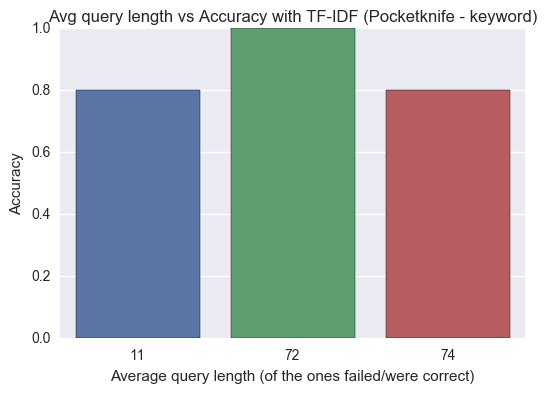

In [579]:
plt.title('Avg query length vs Accuracy with TF-IDF (Pocketknife - keyword)')
sns.barplot(x=[avg_len_query_two_pocket,avg_len_query_one_pocket,avg_len_query_three_pocket],\
           y=[acc_two_pocket,acc_one_pocket,acc_three_pocket])
plt.ylabel('Accuracy')
plt.xlabel('Average query length (of the ones failed/were correct)');

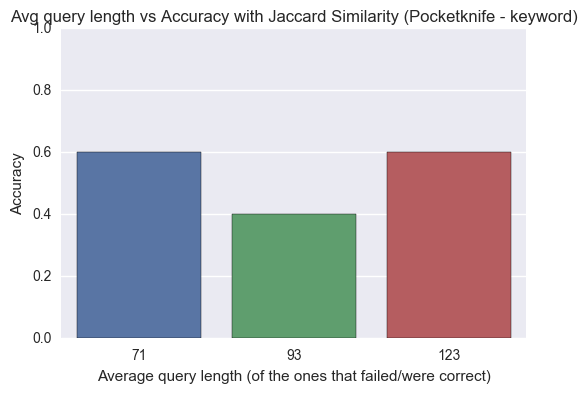

In [578]:
plt.title('Avg query length vs Accuracy with Jaccard Similarity (Pocketknife - keyword)')
sns.barplot(x=[avg_len_query_three_pocket_jacc,avg_query_one_pocket_jacc,avg_len_query_two_pocket_jacc],\
           y=[acc_three_pocket_jacc,acc_one_pocket_jacc,acc_two_pocket_jacc])
plt.ylabel('Accuracy')
plt.xlabel('Average query length (of the ones that failed/were correct)')
plt.ylim(0,1);

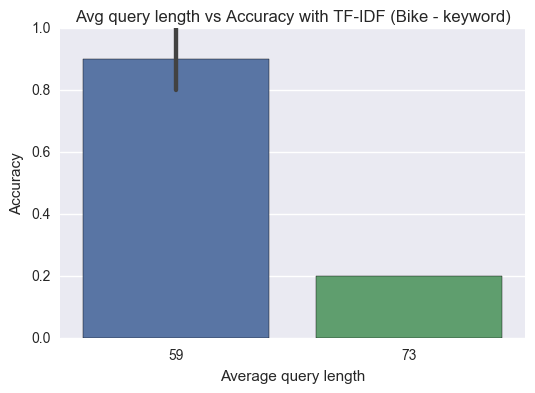

In [570]:
## test bike keyword with TF-IDF
plt.title('Avg query length vs Accuracy with TF-IDF (Bike - keyword)')
sns.barplot(x=[avg_len_query_one_bike,avg_len_query_two_bike,avg_len_query_three_bike],\
           y=[acc_one_bike,acc_two_bike,acc_three_bike])
plt.ylabel('Accuracy')
plt.xlabel('Average query length');

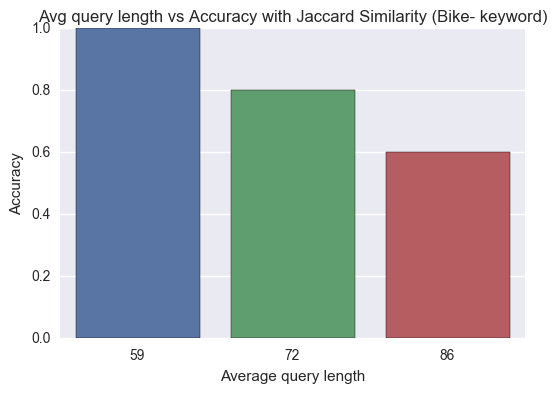

In [575]:
plt.title('Avg query length vs Accuracy with Jaccard Similarity (Bike- keyword)')
sns.barplot(x=[avg_query_one_bike_jacc,avg_len_query_two_bike_jacc,avg_len_query_three_bike_jacc],\
           y=[acc_one_bike_jacc,acc_two_bike_jacc,acc_three_bike_jacc])
plt.ylabel('Accuracy')
plt.xlabel('Average query length')
plt.ylim(0,1);

> In general, our IR system, TF-IDF with cosine similarity, works pretty well unless the query closely resembles a different story chunk or if the query is long. In addition, TF-IDF seems to outperform Jaccard Similarity on the queries tested. 

### Data to evaluate POS/NER

In [430]:
### List of correct person named entities
correct_person_entities = {'ada','alice','ann','atheling','beau','bill','brandy','carroll','chapter','cheshire','dinah',
 'dinn','dodo','dormouse','eaglet','edgar','edwin','elsie','footman','gryphon','hatter','herald','hjckrrh','jack','knave','lacie',
 'lewis', 'lory', 'mabel','magpie','mary','mock','morcar','mouse','normans','northumbria',
 'pat',
 'puss',
 'queen',
 'rabbit',
 'shakespeare',
 'tortoise',
 'treacle',
 'turtle',
 'william'}

correct_person_entities_notprocessed = {'ada',
 'alice',
 'ann',
 'atheling',
 'beau',
 'bill',
 'brandy',
 'carroll',
 'cheshire',
 'conqueror',
 'dodo',
 'dormouse',
 'eaglet',
 'edgar',
 'edwin',
 'elsie',
 'footman',
 'gryphon',
 'hatter',
 'jack',
 'knave',
 'lacie',
 'lewis',
 'lizard',
 'lory',
 'mabel',
 'magpie',
 'mary',
 'morcar',
 'northumbria',
 'quadrille',
 'queen',
 'shakespeare',
 'william'}

## COrrect organization named entities

correct_org_entities = {'dodo','dodo','dodo','mouse','caterpillar','caterpillar',
 'alice','caterpillar','caterpillar','caterpillar','myself','caterpillar','caterpillar','caterpillar','caterpillar','caterpillar','caterpillar',
 'caterpillar','caterpillar','caterpillar','caterpillar','caterpillar','caterpillar','pigeon','pigeon','pigeon','pigeon'
 'footman','duchess','mad','tea','party','hare','mine','dormouse','hatter','dormouse','hatter','dormouse',
 'dormouse',
 'cheshire',
 'duchess',
                        'washing',
 'caterpillar',
 'lobster',
 'quadrille',
 'gryphon',
 'knave',
 'march',}

correct_org_entities_notprocessed ={
 'canary',
 'caterpillar',
 'cheshire',
 'conqueror',
 'dormouse',
 'gryphon',
 'hare',
 'hatter',
 'herald',
 'pigeon',
 'queen',
 'rabbit'}

### Correct date named entities

correct_date_entities = {
 'day',
 'days',
 'half',
 'march',
 'may',
 'minute',
 'minutes',
 'one',
 'summer',
 'three',
 'today',
 'tomorrow',
 'two',
 'week',
 'weeks',
 'winter',
 'year',
 'yesterday'}

correct_date_entities_notprocessed={'day',
 'days',
 'march',
 'summer',
 'today',
 'week',
 'weeks',
 'winter',
 'yesterday'}

correct_propernoun_pos = {
 "'alice",
 "'arrum",
 "'curiouser",
 "'hjckrrh",
 "'how",
 "'i",
 "'moral",
 "'poison",
 "'the",
 "'there",
 "'they",
 "'this",
 "'you",
 'ada',
 'adventures',
 'advice',
 'alice',


 'ann',
 'atheling',
 'australia',
 'beautiful',
 'bee',
 'besides',
 'best',
 'between',
 'bill',
 'boots',
 'canary',
 'canterbury',
 'carroll',
 'cat',
 'cat.',
 'caterpillar',
 'caucus',
 'cheshire',
 'chorus',
 'christmas',
 'coils',

 'conqueror',
 'crab',
 'croquet',
 'derision',
 'dinah',
 'dinn',
 'distraction',
 'dormouse',
 'doth',
 'down',
 'drawling',
 'duchess',
 'duck',
 'eaglet',
 'edgar',
 'edition',
 'edwin',
 'elsie',
 'england',
 'english',
 'esq',
 'evidence',
 'fainting',
 'father',
 'fender',
 'footman',
 'forty',
 'france',
 'french',
 'frog',
 'from',
 'fulcrum',
 'game',
 'gave',
 'geography',
 'grammar',
 'grief',
 'ground',
 'gryphon',
 'gryphon.',
 'hated',
 'hatter',
 'heads',
 'hearthrug',
 'hearts',
 'here',
 'high',
 'him',
 'his',
 'hole',
 'hush',
 'imagine',
 'jack',
 'just',
 'keep',
 'king',
 'kings',
 'knave',
 'know',
 'lacie',
 'latin',
 'latitude',
 'laughing',
 'leave',
 'lewis',
 'little',
 'lizard',
 'lobster',
 'london',
 'longitude',
 'lory',
 'love',
 'ma',
 "ma'am",
 'mabel',
 'mad',
 'magpie',
 'majesty',
 'march',
 'marmalade',
 'mary',
 'may',
 'maybe',
 'mercia',
 'millennium',
 'miss',
 'mock',
 'morcar',
 'more',
 'mouse',
 'mouse.',
 'multiplication',
 'must',
 'myself',
 'mystery',
 'nay',
 'near',
 'never',
 'new',
 'nile',
 'northumbria',
 'outside',
 'owl',
 'panther',
 'paris',
 'party',
 'pat',
 'pennyworth',
 'pepper',
 'persons',
 'pig',
 'pigeon',
 'pinch',
 'please',
 'plenty',
 'pocket',
 'pool',
 'poor',
 'pray',
 'precious',
 'prizes',
 'puss',
 'quadrille',
 'queen',
 'queens',
 'quick',
 'rabbit',
 'race',
 'red',
 'returned',
 'right',
 'rome',
 'run',
 'said',
 'seaography',
 'serpent',
 'seven',
 'shakespeare',
 'shark',
 'she',
 'shoes',
 'sir',
 'sluggard',
 'some',
 'somebody',
 'something',
 'soup',
 'stigand',
 'suppress',
 'swim',
 'table',
 'take',
 'tarts',
 'tea',
 'tears',
 'than',
 'tillie',
 'time',
 'tortoise',
 'trims',
 'turn',
 'turtle',
 'twinkle',
 'uglification',
 'vi',
 'vii',
 'viii',
 'visit',
 'voice',
 'waistcoat',
 'will',
 'william',
 'with',
 'wonderland',
 'writhing',
 'x',
 'xi',
 'xii',
 'zealand'}

correct_vb_pos = {
 "''tis",
 "'allow",
 "'and",
 "'are",
 "'begin",
 "'behead",
 "'by",
 "'call",
 "'come",
 "'consider",
 "'do",
 "'does",
 "'drink",
 "'explain",
 "'fetch",
 "'give",
 "'go",
 "'hand",
 "'have",
 "'he",
 "'hold",
 "'how",
 "'in",
 "'it",
 "'just",
 "'keep",
 "'leave",
 "'let",
 "'of",
 "'speak",
 "'stand",
 "'suppose",
 "'swim",
 "'take",
 "'tell",
 "'turn",
 "'wake",
 "'which",
 "'write",
 'abide',
 'afford',
 'agree',
 'alice',
 'allow',
 'annoy',
 'answer',
 'appear',
 'ask',
 'avoid',
 'be',
 'bear',
 'beat',
 'beautify',
 'become',
 'beg',
 'begin',
 'believe',
 'belong',
 'bend',
 'better',
 'bite',
 'bother',
 'box',
 'break',
 'breathe',
 'bring',
 'burn',
 'call',
 'care',
 'carry',
 'catch',
 'cats',
 'change',
 'choke',
 'clever',
 'climb',
 'come',
 'consider',
 'cost',
 'creep',
 'croquet',
 'cross',
 'cry',
 'curtsey',
 'cut',
 'dare',
 'dear',
 'declare',
 'deny',
 'die',
 'disagree',
 'disobey',
 'dive',
 'doth',
 'double',
 'doubt',
 'draw',
 'dream',
 'drink',
 'drive',
 'drop',
 'dry',
 'dull',
 'ear',
 'eat',
 'eaten',
 'encourage',
 'enjoy',
 'escape',
 'examine',
 'execute',
 'execution',
 'explain',
 'fall',
 'feel',
 'fetch',
 'fig',
 'find',
 'finish',
 'finished',
 'fix',
 'fly',
 'follow',
 'forget',
 'forgotten',
 'frighten',
 'gather',
 'get',
 'give',
 'go',
 'grin',
 'grow',
 'grunt',
 'guard',
 'guess',
 'happen',
 'hear',
 'help',
 'herself',
 'hide',
 'hold',
 'hope',
 'imagine',
 'improve',
 'injure',
 'interrupt',
 'introduce',
 'invent',
 'join',
 'keep',
 'kettle',
 'kick',
 'kill',
 'kiss',
 'kneel',
 'knock',
 'knot',
 'know',
 'land',
 'learn',
 'leave',
 'lie',
 'like',
 'listen',
 'live',
 'look',
 'lose',
 'make',
 'manage',
 'mark',
 'matter',
 'mean',
 'measure',
 'meet',
 'miss',
 'mistake',
 'move',
 'mustard',
 'needs',
 'notice',
 'nurse',
 'offend',
 'offer',
 'open',
 'pass',
 'pinch',
 'play',
 'please',
 'pocket',
 'pop',
 'prevent',
 'proceed',
 'prosecute',
 'prove',
 'purpose',
 'push',
 'put',
 'queer',
 'quiver',
 'reach',
 'read',
 'remain',
 'remark',
 'remember',
 'repeat',
 'rest',
 'rise',
 'round',
 'rubbed',
 'run',
 'savage',
 'save',
 'say',
 'sea',
 'see',
 'seem',
 'sell',
 'send',
 'set',
 'settle',
 'show',
 'shrink',
 'shut',
 'sign',
 'signify',
 'sing',
 'sink',
 'sir',
 'sit',
 'sneeze',
 'sound',
 'speak',
 'spell',
 'squeeze',
 'stairs',
 'stand',
 'stay',
 'stoop',
 'stop',
 'sugar',
 'suit',
 'suppose',
 'swallow',
 'sweet',
 'swim',
 'take',
 'talk',
 'taste',
 'tell',
 'think',
 'thoroughly',
 'throw',
 'thump',
 'till',
 'touch',
 'treacle',
 'tremble',
 'trot',
 'try',
 'turn',
 'twice',
 'twist',
 'uglify',
 'understand',
 'undo',
 'untwist',
 'use',
 'wag',
 'walk',
 'want',
 'wash',
 'watch',
 'whisper',
 'whistle',
 'win',
 'wink',
 'wish',
 'wonder',
 'work',
 'worry',
 'write'}

## correct language named entities

correct_lang_entities = {'english', 'french'}

correct_lang_entities_notprocessed = {'english', 'french'}

## Correct plural common nouns

correct_nns_pos = {
 "'boots",
 "'creatures",
 "'crumbs",
 "'explanations",
 "'flamingoes",
 "'seals",
 "'soles",
 'accounts',
 'adventures',
 'afterwards',
 'animals',
 'answers',
 'apples',
 'arches',
 'arguments',
 'arms',
 'attempts',
 'attends',
 'axes',
 'backs',
 'balls',
 'banks',
 'bats',
 'beasts',
 'beds',
 'bells',
 'besides',
 'birds',
 'blades',
 'blasts',
 'blows',
 'bones',
 'books',
 'boots',
 'branches',
 'buttons',
 'cakes',
 'cards',
 'cares',
 'cartwheels',
 'cats',
 'cattle',
 'chains',
 'changes',
 'charges',
 'children',
 'chimneys',
 'clubs',
 'comfits',
 'conversations',
 'corners',
 'couples',
 'courtiers',
 'creatures',
 'cries',
 'croquet',
 'crumbs',
 'cupboards',
 'curls',
 'currants',
 'dainties',
 'daisies',
 'dates',
 'days',
 'dears',
 'desks',
 'diamonds',
 'difficulties',
 'directions',
 'dishes',
 'dogs',
 'doors',
 'downwards',
 'ears',
 'eats',
 'editions',
 'educations',
 'eels',
 'eggs',
 'elbows',
 'executions',
 'extras',
 'eyelids',
 'eyes',
 'feathers',
 'feelings',
 'feet',
 'ferrets',
 'figures',
 'fishes',
 'fits',
 'flamingoes',
 'flappers',
 'flowers',
 'footmen',
 'footsteps',
 'forwards',
 'fountains',
 'frames',
 'friends',
 'furrows',
 'gallons',
 'games',
 'gardeners',
 'girls',
 'gloves',
 'grins',
 'guests',
 'hands',
 'hatters',
 'heads',
 'hearts',
 'hedgehogs',
 'hedges',
 'heels',
 'hers',
 'histories',
 'hours',
 'houses',
 'inches',
 'inwards',
 'irons',
 'jaws',
 'joys',
 'jurors',
 'jurymen',
 'knuckles',
 'lamps',
 'leaders',
 'leaves',
 'legs',
 'lessons',
 'letters',
 'limbs',
 'lines',
 'lips',
 'listeners',
 'lives',
 'lobsters',
 'locks',
 'machines',
 'mallets',
 'manners',
 'maps',
 'matters',
 'men',
 'messages',
 'mice',
 'miles',
 'minutes',
 'morals',
 'mouths',
 'names',
 'newspapers',
 'noises',
 'officers',
 'ones',
 'onions',
 'others',
 'pairs',
 'partners',
 'parts',
 'pebbles',
 'pencils',
 'people',
 'pictures',
 'pieces',
 'pigs',
 'places',
 'plates',
 'players',
 'pounds',
 'presents',
 'pretexts',
 'prizes',
 'processions',
 'questions',
 'rabbits',
 'rats',
 'ravens',
 'reasons',
 'reeds',
 'refreshments',
 'remarks',
 'remedies',
 'riddles',
 'ridges',
 'ringlets',
 'roots',
 'roses',
 'rules',
 'sands',
 'saucepans',
 'serpents',
 'sharks',
 'shelves',
 'shillings',
 'shoes',
 'shoulders',
 'sides',
 'singers',
 'sisters',
 'sizes',
 'slates',
 'soldiers',
 'sorrows',
 'sorts',
 'sounds',
 'spades',
 'spectacles',
 'stairs',
 'sticks',
 'stockings',
 'strings',
 'subjects',
 'tails',
 'tales',
 'tarts',
 'tastes',
 'teacups',
 'tears',
 'teeth',
 'telescopes',
 'terms',
 'theirs',
 'things',
 'thoughts',
 'times',
 'toes',
 'tones',
 'tops',
 'towards',
 'traps',
 'trees',
 'trials',
 'turns',
 'turtles',
 'upstairs',
 'variations',
 'verses',
 'voices',
 'waters',
 'ways',
 'weeks',
 'whiles',
 'whiskers',
 'whispers',
 'wings',
 'wits',
 'words',
 'works',
 'yards',
 'years'}

correct_person_lemm = {'ada',
 'alice',
 'ann',
 'atheling',
 'beau',
 'bill',
 'brandy',
 'carroll',
 'cheshire',
 'conqueror',
 'dinn',
 'dodo',
 'dormouse',
 'eaglet',
 'edgar',
 'edwin',
 'gryphon',
 'hatter',
 'herald',
 'hjckrrh',
 'jack',
 'lacie',
 'lewis',
 'lory',
 "ma'am",
 'mabel',
 'magpie',
 'mary',
 'mercia',
 'morcar',
 'mouse',
 'northumbria',
 'pepper',
 'pigeon',
 'queen',
 'rabbit',
 'shakespeare',
 'tortoise',
 'turtle',
 'twinkle', 'william'}

correct_org_lemm = {
 'cheshire',
 'court',
 'dodo',
 'dormouse',
 'duchess',
 'grammar',
 'gryphon',
 'hare',
 'hatter',
 'hearthrug',
 'latin',
 'mouse',
 'pigeon',
 'quadrille',
 'queen',
 'rabbit',
 'turtle'}

correct_date_lemm = {

 'day',

 'march',
 'may',
 'minute',


 'summer',

 'today',
 'tomorrow',

 'week',
  'yesterday'}